## Tabla de contenidos

* [Introucción](#intro) 
* [Objetivos](#objectives)
* [Preparación de datos](#data_review)
* [Entrenamiento del Modelo](#trainning)
* [Análisis del modelo](#análisis)
* [Conclusiones](#end)

## Introducción

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.

## Objetivos

A Rusty Bargain le interesa:

- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

### Inicialización

In [1]:
# Librerías usadas en el proyecto 

import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error


### Carga de datos

In [2]:
# Carga los datos en un DataFrame

df = pd.read_csv('/datasets/car_data.csv')
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [4]:
# Obtiene los índices del objeto
index_obj = df.columns

# Convierte los índices del objeto a una lista de "strings"
index_list = [str(item) for item in index_obj.tolist()]

# Función pasa convertir a "string a "snake_case"
def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# Transforma los títulos de las columnas a "snake_case" 
df.columns = [to_snake_case(item) for item in index_list]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [5]:
# Convierte los títulos de las columnas a minúsculas

#df = df.rename(columns={
#'NumberOfPictures':'numberofpictures',
#'b':'B'
#})
#df.columns= df.columns.str.lower()
#df.columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Las siguientes columnas cuentan con valores ausentes: 1) "vehicletype", 2) "gearbox", 3) "model", 4) "fueltype", 5) "notrepaired". Todas corresponden a variables cualitativas. Se investigará el tratamiento de valores ausentes caso por caso. 

### Preprocesamieto de datos 

#### Tratamiento de valores ausentes

In [7]:
# Investigación de valores ausentes

qualitative_variables = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired']

for variable in qualitative_variables:
    print(f'Datos ausentes de la variable {variable}')  
    print(f'Cantidad: {df[variable].isna().sum()}')
    print(f'Porcentaje: {(df[variable].isna().sum()/len(df))*100:.1f}')
    print()

Datos ausentes de la variable vehicle_type
Cantidad: 37490
Porcentaje: 10.6

Datos ausentes de la variable gearbox
Cantidad: 19833
Porcentaje: 5.6

Datos ausentes de la variable model
Cantidad: 19705
Porcentaje: 5.6

Datos ausentes de la variable fuel_type
Cantidad: 32895
Porcentaje: 9.3

Datos ausentes de la variable not_repaired
Cantidad: 71154
Porcentaje: 20.1



Al corresponder todos estos campos a valores cualitativos, no se pueden realizar operaciones para el relleno de datos. En ese sentido, se rellenarán todos los campos con el "string" "unknown". 

In [8]:
# Relleno de datos cualitativos con el string "unknown"

for variable in qualitative_variables:
    df[variable] = df[variable].fillna("unknown")

df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        354369 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

#### Cambio de tipo de datos

Las variables "date_crawled", "date_created" y "last_seen", se encuentran almacenadas con el tipo de datos "object". Se transformarán las mismas a "DateTime" con formato ISO 8601.  

In [9]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [66]:
# Cambio de tipo de dato a fecha

df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%d/%m/%Y %H:%M').dt.strftime('%Y-%m-%dT%H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%d/%m/%Y %H:%M').dt.strftime('%Y-%m-%dT%H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%d/%m/%Y %H:%M').dt.strftime('%Y-%m-%dT%H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        354369 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [67]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24T11:52:00,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24T00:00:00,0,70435,2016-04-07T03:16:00
1,2016-03-24T10:58:00,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24T00:00:00,0,66954,2016-04-07T01:46:00
2,2016-03-14T12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14T00:00:00,0,90480,2016-04-05T12:47:00
3,2016-03-17T16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17T00:00:00,0,91074,2016-03-17T17:40:00
4,2016-03-31T17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31T00:00:00,0,60437,2016-04-06T10:17:00


In [68]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%dT%H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%dT%H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%dT%H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [14]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:00,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:00


#### Eliminación de valores duplicados

In [15]:
# Verificación de valores duplicados

df.duplicated().sum()

262

In [16]:
# Porcentaje de valor duplciados

(df.duplicated().sum() / df.shape[0])*100

0.07393423239617461

In [17]:
# Eliminación de valores duplicados

df = df.drop_duplicates().reset_index(drop=True)
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:00,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:00


#### Conclusiones intermedias

1. Se cambiaron los títulos de las columnas a minúsculas.
2. Se rellenaron los datos cualitativos ausentes con "unkwnon".
3. El tipo de dato de fecha se transformó de "datetime".
4. Se eliminaron los registros duplicados (0.07%).

### Análisis exploratorio de datos


Para el análisis exploratorio de datos, se investigará el comportamiento de las variables cuantitativas. Se retirarán del análisis, las variables que (en principio) no incidirían en la modelación ('registration_month' y 'postal_code') 

In [18]:
quantitative_variables = ['price', 'registration_year', 'power', 
                          'mileage', 'number_of_pictures']

In [19]:
df.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000,354107.0,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684,5.714182,0.0,50507.145030
std,4514.338584,90.261168,189.914972,37906.590101,3.726682,0.0,25784.212094
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49406.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


#### Histogramas

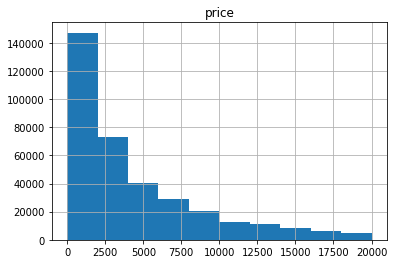

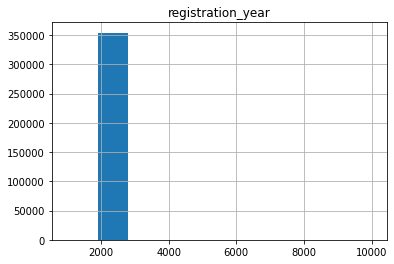

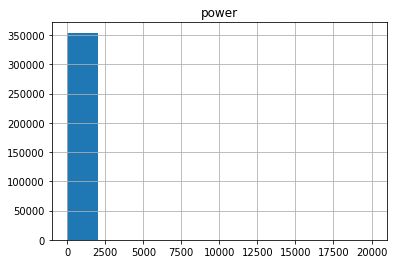

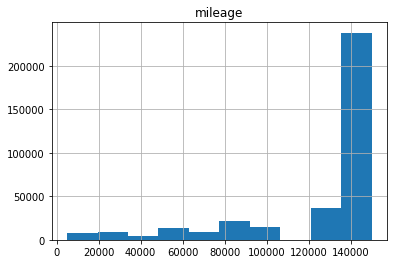

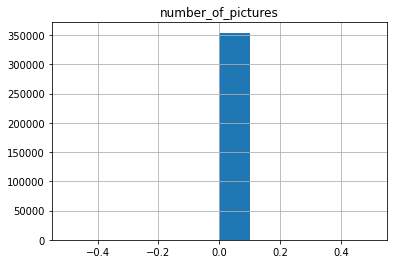

In [20]:
for variable in range(len(quantitative_variables)):
    df.hist(quantitative_variables[variable])

Se ajustará el rango y número de contenedores de los histogramas de las variables "registrationyear", "power". Al parecer no se publicaron fotos de ningún vehículo ("numberofpictures" es igual a cero en todos los registros).

Text(0.5, 1.0, 'registration_year')

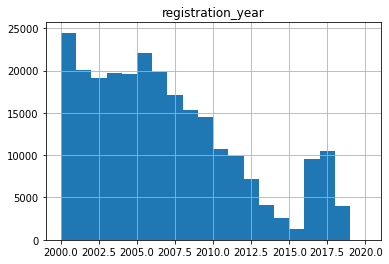

In [21]:
df["registration_year"].hist(bins = 20, range = (2000, 2020))
plt.title('registration_year')

Text(0.5, 1.0, 'power')

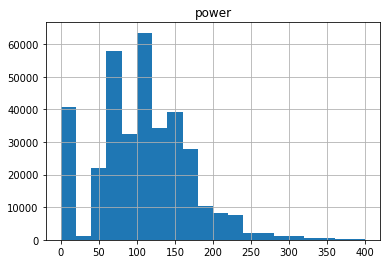

In [22]:
df["power"].hist(bins = 20, range = (0, 400))
plt.title('power')

#### Diagramas de Caja

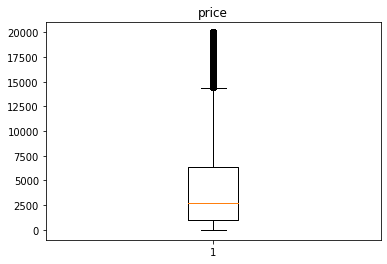

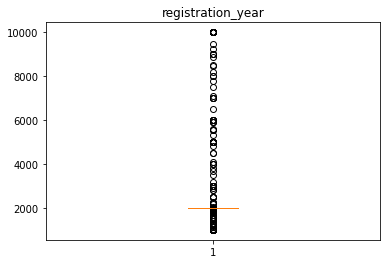

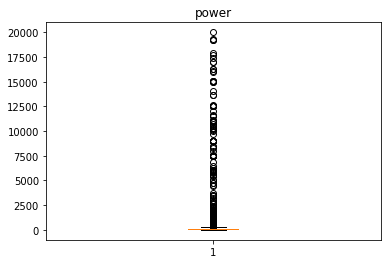

Error in callback <function flush_figures at 0x7fdf736c7ee0> (for post_execute):


KeyboardInterrupt: 

In [23]:
for variable in quantitative_variables:
    plt.figure()  
    plt.boxplot(df[variable])
    plt.title(variable)

#### Estudio y tratamiento de valores atípicos

In [24]:
# Funciones para el cálculo de límites de valores atípicos 

def lower_limit(Q1,Q3):
    IQR = Q3 -Q1
    lower = Q1 - 1.5*IQR
    return lower

def upper_limit(Q1,Q3):
    IQR = Q3 -Q1
    upper = Q3 + 1.5*IQR
    return upper

In [25]:
# Función para el cáculo de cuantiles

def quantiles(vector):
    Q1 = vector.quantile(0.25)
    Q3 = vector.quantile(0.75)
    return Q1, Q3

In [26]:
# Price quantiles
price = df['price']
quantiles(price)

(1050.0, 6400.0)

In [27]:
# Upper limit price
upper_limit(1050.0, 6400.0)

14425.0

In [28]:
# "registration_year" quantiles

registration_year = df['registration_year']
quantiles(registration_year)

(1999.0, 2008.0)

In [29]:
# "registration_month" quantiles

registration_month = df['registration_month']
quantiles(registration_month)

(3.0, 9.0)

In [30]:
# Lower limit "registration_year"
lower_limit(1999.0, 2008.0)

1985.5

In [31]:
# Upper limit "registration_year"
upper_limit(1999.0, 2008.0)

2021.5

In [32]:
# "power" quantiles

power = df['power']
quantiles(power)

(69.0, 143.0)

In [33]:
# Upper limit "power"
upper_limit(69.0, 143.0)

254.0

In [34]:
# "mileage" quantiles

mileage = df['mileage']
quantiles(mileage)

(125000.0, 150000.0)

In [35]:
# Lower limit "mileage"
lower_limit(125000.0, 150000.0)

87500.0

In [36]:
# Funciones para el cálculo de porcentajes de valores atípicos a ser eliminados

def atypical_percentages_lower(vector, lower_threshold, dataframe):
    sum_vector = (vector<lower_threshold).sum()
    total_df = dataframe.shape[0]
    percentage = (sum_vector/total_df)*100
    return percentage

def atypical_percentages_upper(vector, upper_threshold, dataframe):
    sum_vector = (vector>upper_threshold).sum()
    total_df = dataframe.shape[0]
    percentage = (sum_vector/total_df)*100
    return percentage

In [37]:
# Porcentaje de datos atípicos a ser eliminados (upper end "price")
atypical_percentages_upper(price, 14425.0, df)

5.356290612724403

In [38]:
# Porcentaje de datos atípicos a ser eliminados (lower end "price")
atypical_percentages_lower(price, 100, df) 

3.759033286548981

In [39]:
# Porcentaje de datos atípicos a ser eliminados (lower end "registration_year")
atypical_percentages_lower(registration_year, 1985.5, df)

1.7508832076180363

In [40]:
# Porcentaje de datos atípicos a ser eliminados (upper end "registration_year")
atypical_percentages_upper(registration_year, 2021.5, df)

0.029652054322563518

In [41]:
# Porcentaje de datos atípicos a ser eliminados (lower end "registration_month")
atypical_percentages_lower(registration_month, 1, df)

10.546812121759807

In [42]:
# Porcentaje de datos atípicos a ser eliminados (upper end "power")
atypical_percentages_upper(power, 254.0, df)

2.07140779481908

In [43]:
# Porcentaje de datos atípicos a ser eliminados (lower end "power")
atypical_percentages_lower(power, 100, df)

43.53684055949191

In [44]:
# Calcula el valor de la mediana para todos los valores mayores a 100 HP
median = statistics.median([x for x in df['power'] if x >= 100])

# Reemplazo de los valores menores a 100 HP con el valor de la mediana 
df['power'] = [median if x < 100 else x for x in df['power']]

# Verificacion de los reemplazos
df['power'].describe()


count    354107.000000
mean        148.319429
std         181.787083
min         100.000000
25%         131.000000
50%         140.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [45]:
# Porcentaje de datos atípicos a ser eliminados (lower end "mileage")
atypical_percentages_lower(mileage, 87500.0, df)

15.028508332227265

In [46]:
# Almacena los datos sin valores atípicos en un DataFrame separado

df_cleaned = df[(df['price'] < 14425)
                            &(df['price'] > 100)
                             &(df['registration_year'] < 2021)
                            &(df['registration_month'] > 0)
                            &(df['registration_year'] >1985)
                             &(df['power'] < 254)
                             &(df['mileage'] > 87500)]
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245071 entries, 2 to 354106
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        245071 non-null  datetime64[ns]
 1   price               245071 non-null  int64         
 2   vehicle_type        245071 non-null  object        
 3   registration_year   245071 non-null  int64         
 4   gearbox             245071 non-null  object        
 5   power               245071 non-null  float64       
 6   model               245071 non-null  object        
 7   mileage             245071 non-null  int64         
 8   registration_month  245071 non-null  int64         
 9   fuel_type           245071 non-null  object        
 10  brand               245071 non-null  object        
 11  not_repaired        245071 non-null  object        
 12  date_created        245071 non-null  datetime64[ns]
 13  number_of_pictures  245071 no

In [47]:
df_cleaned.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,245071.000000,245071.000000,245071.000000,245071.000000,245071.000000,245071.0,245071.000000
mean,3580.287896,2002.778387,140.775559,142277.972506,6.404805,0.0,50698.982291
std,3189.823228,5.810663,26.836519,16486.548164,3.353962,0.0,25566.911800
min,101.000000,1986.000000,100.000000,90000.000000,1.000000,0.0,1067.000000
25%,1199.000000,1999.000000,125.000000,150000.000000,4.000000,0.0,30625.000000
50%,2500.000000,2002.000000,140.000000,150000.000000,6.000000,0.0,49525.000000
75%,5000.000000,2006.000000,140.000000,150000.000000,9.000000,0.0,71065.000000
max,14400.000000,2019.000000,253.000000,150000.000000,12.000000,0.0,99998.000000


#### Estudio de parámetros principales sin valores atípicos

#### Histogramas

Text(0.5, 1.0, 'price')

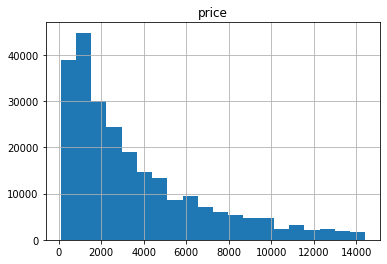

In [48]:
df_cleaned["price"].hist(bins = 20, range = (100, 14425))
plt.title('price')

Text(0.5, 1.0, 'registration_year')

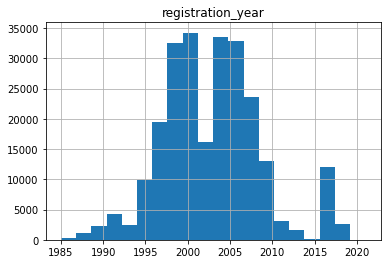

In [49]:
df_cleaned["registration_year"].hist(bins = 20, range = (1985, 2021))
plt.title('registration_year')

Text(0.5, 1.0, 'power')

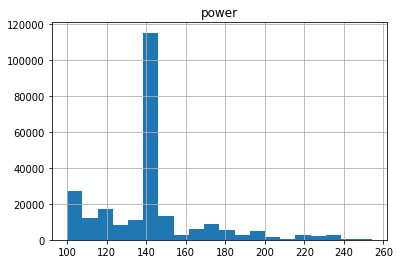

In [50]:
df_cleaned["power"].hist(bins = 20, range = (100, 254))
plt.title('power')

Text(0.5, 1.0, 'mileage')

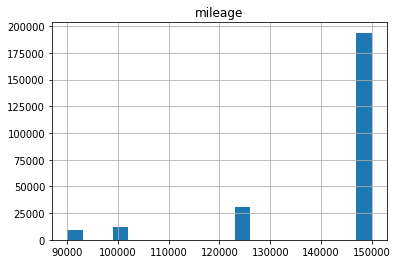

In [51]:
df_cleaned["mileage"].hist(bins = 20, range = (90000, 150000))
plt.title('mileage')

#### Correlaciones

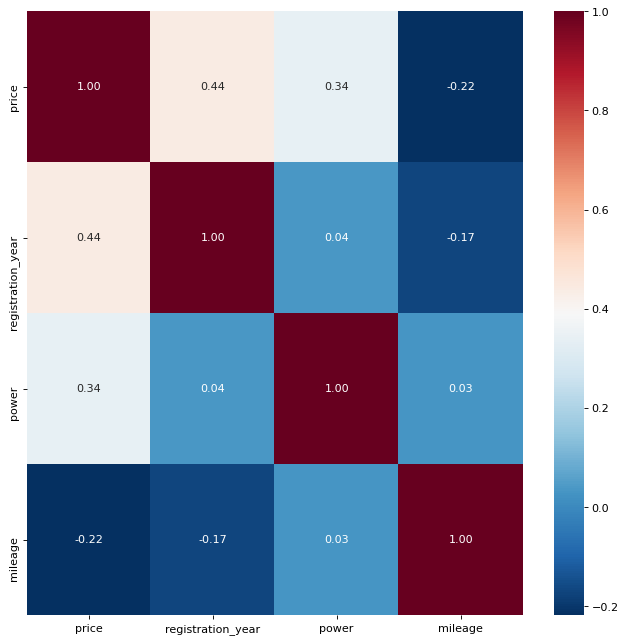

In [52]:
# Determina las correlaciones entre variables cuantitativas con correlación Pearson

df_cuantitative = df_cleaned[["price", "registration_year", "power", "mileage"]]
plt.figure(figsize=(10, 10), dpi=80)
sns.heatmap(df_cuantitative.corr(), annot=True, cmap="RdBu_r", fmt=".2f")
plt.show()

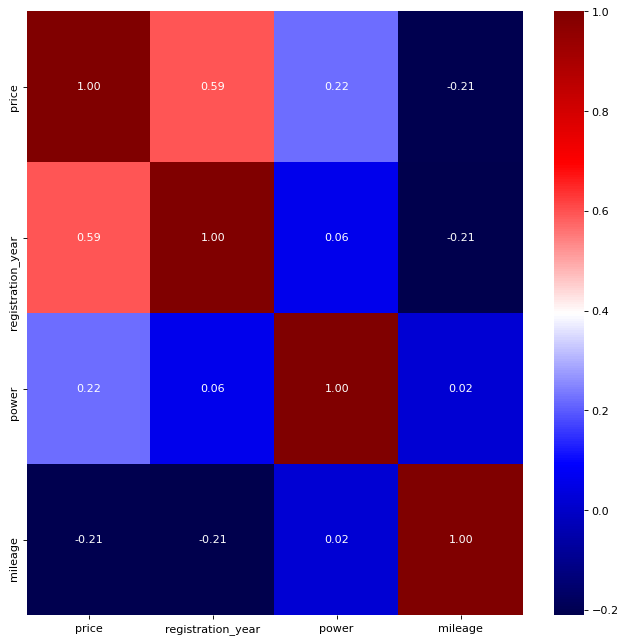

In [53]:
# Determina las correlaciones entre variables cuantitativas con correlación Spearman

plt.figure(figsize=(10, 10), dpi=80)
sns.heatmap(df_cuantitative.corr(method="spearman"), annot=True, cmap="seismic", fmt=".2f")
plt.show()

#### Conclusiones intermedias

1. Se eliminaron los valores atípicos de las variables "price" (9.1 %), "registrationyear" (1.78 %), "registrationyear" (10.5 %), "power" (2.07 %), y "mileage" (15.03 %), en función del cálculo de cuantiles. 
2. En virtud de que existían valores de precio desde cero euros, lo cual evidentemente no es real, se fijó un precio arbitrario mínimo de 100 euros. 
3. De igual forma, los valores de potencia partían desde 0 HP, lo cual tampoco es real, por lo que se investigó la posibilidad de establecer la potencia mínima de los vehículos en 100 HP, en virtud de que este es un valor mínimo de potencia para vehículos de acuerdo a una revisión rápida de datos en internet. Sin embargo, el porcentaje de datos menor a 100 HP es de aproximadamente 43 % por lo que no pueden ser eliminados. En ese sentido, se decidió reeemplazar los valores con el dato de la mediana. 
4. El estudio de correlaciones entre variables cuantitativas determina que existen correlaciones (usando el método Pearson) positivas entre precio-año de registro (0.42) y precio-pontencia (0.34). Por otra parte, existe una correlación negativa entre precio-millaje (-0.22). Usando el método Spearman, los resultados de las correlaciones son:  precio-año de registro (0.59), precio-pontencia (0.22) y precio-millaje (-0.21).En ese sentido, se aprecia que para las correlacioens positivas existe una variación de resultados en función del método de correlación aplicado. 

## Entrenamiento del modelo 

In [54]:
df_cleaned.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
2,2016-03-14 12:52:00,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,140.0,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,140.0,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:00
5,2016-04-04 17:36:00,650,sedan,1995,manual,102.0,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:00
6,2016-04-01 20:48:00,2200,convertible,2004,manual,109.0,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:00


Antes de iniciar la modelación, se eliminarán categorías que no sean útiles. Por otra parte,  se realizará una codificación de las variables categóricas para incluirlas en los análisis.  

In [55]:
# Eliminación de características que no son útiles en la modelación

df_cleaned = df_cleaned.drop(['date_crawled', 'date_created', 'number_of_pictures', 'last_seen', 'postal_code', 'model', 'brand'], axis=1,)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245071 entries, 2 to 354106
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               245071 non-null  int64  
 1   vehicle_type        245071 non-null  object 
 2   registration_year   245071 non-null  int64  
 3   gearbox             245071 non-null  object 
 4   power               245071 non-null  float64
 5   mileage             245071 non-null  int64  
 6   registration_month  245071 non-null  int64  
 7   fuel_type           245071 non-null  object 
 8   not_repaired        245071 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 18.7+ MB


In [56]:
#codigo agregado por el revisor para ejemplificar el comentario anterior.
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_cleaned.groupby('brand')['model'].value_counts())

KeyError: 'brand'

In [ ]:
## Codificación de características categóricas

# Selección de carácterísticas a codificar
cols_to_encode = ['vehicle_type', 'gearbox', 'power', 'fuel_type', 'not_repaired']
df_to_encode = df_cleaned[cols_to_encode]

# Crea la instancia para la codificación
encoder = OrdinalEncoder()

# Ajusta y transforma las columnas seleccionadas usando el codificador 
encoded_values = encoder.fit_transform(df_to_encode)

# Reemplaza las columnas originales con los valroes codificados
df_cleaned[cols_to_encode] = encoded_values
# Verifica las codificación de características categóricas
df_modelling = df_cleaned
df_modelling.head()


In [ ]:
# Verificación de valores ausentes en la matriz para modelación
df_modelling.isnull().mean()

In [ ]:
# Verificación de registros duplicados en la matriz para modelación
df_modelling.duplicated().sum()

Al parecer la codificación creo registros duplciados. Los mismos serán eliminados.

In [ ]:
# Eliminación de registros duplicadosp or la codificación
df_modelling.drop_duplicates(inplace=True)

In [ ]:
# Verificación de registros duplicados en la matriz para modelación
df_modelling.duplicated().sum()

In [ ]:
# Convertir todas las columnas enteros
df_modelling = df_modelling.astype(int)
df_modelling.info()

Una vez que se han seleccionado las características, y que las características categóricas han sido codificadas, podemos proceder con el entrenamiento de los modelos.

In [ ]:
# Selección de conjuntos de entrenamiento, prueba y validación

train_X, test_X, train_y, test_y = train_test_split(df_modelling.drop(['price'], axis=1),
                                                      df_modelling['price'], 
                                                    test_size=0.2, 
                                                    random_state=12345)

valid_X, test_X, valid_y, test_y = train_test_split(test_X,
                                                      test_y, 
                                                    test_size=0.1, 
                                                    random_state=12345)

In [ ]:
# Verificación de las dimensiones de los conjuntos de entrenamiento, prueba y validación
train_X.shape, valid_X.shape, test_X.shape, train_y.shape, valid_y.shape, test_y.shape

Ahora, se definirá una función para la evaluación de los modelos. El requerimiento del cliente es usar la métrica "RSME". Esta función se utilizará en el parámtro "scoring" para la construcción de los modelos.   

In [ ]:
# Define una función para el "scoring"

def rmse(y_true, y_pred):
    """
    Calcula la raíz del error cuadrático medio 
    """
    return (mean_squared_error(y_true, y_pred))**0.5

In [ ]:
# Modelo lineal

best_rmse = 0
start_time = time.time()

lr = LinearRegression()
grid_search = GridSearchCV(lr, param_grid={}, cv=5, scoring=make_scorer(rmse))
grid_search.fit(train_X, train_y)

best_estimator = grid_search.best_estimator_.fit(train_X, train_y)
preds = grid_search.best_estimator_.predict(valid_X)

best_rmse = rmse(valid_y, preds)
end_time = time.time() - start_time

print(f"El mejor modelo es: {best_estimator}")
print(f"El mejor puntaje de rmse es: {best_rmse}")
print(f"El tiempo de procesamiento fue: {end_time}")


In [ ]:
# Bosque aleatorio 

best_rmse = 0
start_time = time.time()

rf = RandomForestRegressor(random_state=12345)
grid_search = GridSearchCV(rf, param_grid={'n_estimators': [20, 30, 40, 50]}, cv=5, scoring=make_scorer(rmse))
grid_search.fit(train_X, train_y)

best_estimator = grid_search.best_estimator_.fit(train_X, train_y)
preds = grid_search.best_estimator_.predict(valid_X)

best_rmse = rmse(valid_y, preds)
end_time = time.time() - start_time

print(f"El mejor modelo es: {best_estimator}")
print(f"El mejor puntaje de rmse es: {best_rmse}")
print(f"El tiempo de procesamiento fue: {end_time}")


In [ ]:
# Modelo Catboost

cat_features = ['vehicle_type',  'gearbox', 'fuel_type', 'not_repaired']

best_rmse = 0
start_time = time.time()

cat = CatBoostRegressor(learning_rate=0.9, loss_function='RMSE',
                        random_seed=12345)
grid_search = GridSearchCV(cat, param_grid={'iterations': [20, 30, 40, 50]}, cv=5, scoring=make_scorer(rmse))
grid_search.fit(train_X, train_y)

best_estimator = grid_search.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=False)
#best_iteration = cat.get_best_iteration()

preds = grid_search.best_estimator_.predict(valid_X)

best_rmse = rmse(valid_y, preds)
end_time = time.time() - start_time

print(f"El mejor puntaje de rmse es: {best_rmse}")
print(f"El tiempo de procesamiento fue: {end_time}")

### Resumen de resultados

|    **Modelo**    | **RMSE** | **Tiempo** |
|:----------------:|:--------:|:----------:|
|      Lineal      |  2360.50 |    0.76    |
| Bosque Aleatorio |  1667.13 |   253.98   |
|     CatBoost     |  1639.91 |    25.12   |

### Conclusiones intermedias

1. Los modelos de Bosque Aleatorio y "CatBoost" pasan la prueba de cordura al presentar un mejor resultado en la métrica "RMSE" que el modelo lineal.
2. El modelo de "CatBoost" presenta el mejor puntaje de RSME y tiempo de ejecución.

## Análisis del modelo

In [ ]:
# Modelo lineal

best_rmse = 0
start_time = time.time()

lr = LinearRegression()
grid_search = GridSearchCV(lr, param_grid={}, cv=5, scoring=make_scorer(rmse))
grid_search.fit(train_X, train_y)

best_estimator = grid_search.best_estimator_.fit(train_X, train_y)
preds = grid_search.best_estimator_.predict(test_X)

best_rmse = rmse(test_y, preds)
end_time = time.time() - start_time

print(f"Puntaje de rmse en el conjunto de prueba: {best_rmse}")
print(f"El tiempo de procesamiento fue: {end_time}")

In [ ]:
# Bosque aleatorio 

best_rmse = 0
start_time = time.time()

rf = RandomForestRegressor(random_state=12345)
grid_search = GridSearchCV(rf, param_grid={'n_estimators': [20]}, cv=5, scoring=make_scorer(rmse))
grid_search.fit(train_X, train_y)

best_estimator = grid_search.best_estimator_.fit(train_X, train_y)
preds = grid_search.best_estimator_.predict(test_X)

best_rmse = rmse(test_y, preds)
end_time = time.time() - start_time

print(f"Puntaje de rmse en el conjunto de prueba: {best_rmse}")
print(f"El tiempo de procesamiento fue: {end_time}")

In [ ]:
# Modelo Catboost

cat_features = ['vehicle_type',  'gearbox', 'fuel_type', 'not_repaired']

best_rmse = 0
start_time = time.time()

cat = CatBoostRegressor(learning_rate=0.9, loss_function='RMSE',
                        random_seed=12345)
grid_search = GridSearchCV(cat, param_grid={'iterations': [20, 30, 40, 50]}, cv=5, scoring=make_scorer(rmse))
grid_search.fit(train_X, train_y)

best_estimator = grid_search.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=False)
#best_iteration = cat.get_best_iteration()

preds = grid_search.best_estimator_.predict(test_X)

best_rmse = rmse(test_y, preds)
end_time = time.time() - start_time

print(f"Puntaje de rmse en el conjunto de prueba: {best_rmse}")
print(f"El tiempo de procesamiento fue: {end_time}")

### Resumen de resultados

|    **Modelo**    | **RMSE** | **Tiempo** |
|:----------------:|:--------:|:----------:|
|      Lineal      |  2354.16 |    1.04    |
| Bosque Aleatorio |  1660.48 |    49.01  |
|     CatBoost     |  1621.82 |    24.99  |

### Conclusiones intermedias

1. Se confirm

### Conclusiones 

1. Se cambiaron los títulos de las columnas a minúsculas.
2. Se rellenaron los datos cualitativos ausentes con "unkwnon".
3. El tipo de dato de fecha se transformó de "datetime".
4. Se eliminaron los registros duplicados (0.07%).
5. Se eliminaron los valores atípicos de las variables "price" (9.1 %), "registrationyear" (1.78 %), "registrationyear" (10.5 %), "power" (2.07 %), y "mileage" (15.03 %), en función del cálculo de cuantiles.
6. En virtud de que existían valores de precio desde cero euros, lo cual evidentemente no es real, se fijó un precio arbitrario mínimo de 100 euros.
7. De igual forma, los valores de potencia partían desde 0 HP, lo cual tampoco es real, por lo que se investigó la posibilidad de establecer la potencia mínima de los vehículos en 100 HP, en virtud de que este es un valor mínimo de potencia para vehículos de acuerdo a una revisión rápida de datos en internet. Sin embargo, el porcentaje de datos menor a 100 HP es de aproximadamente 43 % por lo que no pueden ser eliminados. En ese sentido, se decidió reeemplazar los valores con el dato de la mediana.
8. El estudio de correlaciones entre variables cuantitativas determina que existen correlaciones (usando el método Pearson) positivas entre precio-año de registro (0.42) y precio-pontencia (0.34). Por otra parte, existe una correlación negativa entre precio-millaje (-0.22). Usando el método Spearman, los resultados de las correlaciones son:  precio-año de registro (0.59), precio-pontencia (0.22) y precio-millaje (-0.21).En ese sentido, se aprecia que para las correlacioens positivas existe una variación de resultados en función del método de correlación aplicado. 
9. Los modelos de Bosque Aleatorio y "CatBoost" pasan la prueba de cordura al presentar un mejor resultado en la métrica "RMSE" que el modelo lineal.
10. El modelo de "CatBoost" presenta el mejor puntaje de RSME y tiempo de ejecución.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [x]  El código no tiene errores- [x]  Las celdas con el código han sido colocadas en orden de ejecución- [x]  Los datos han sido descargados y preparados- [x]  Los modelos han sido entrenados
- [x]  Se realizó el análisis de velocidad y calidad de los modelos